In [94]:
!python -m pip install prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import packages

In [105]:
import pandas as pd 
from prophet import Prophet
from IPython.display import display
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import prophet


## Load the data


In [96]:
url = "https://raw.githubusercontent.com/nicknochnack/TimeSeriesForecastingProphet/main/dataset.csv"
df = pd.read_csv(url)
print(df.shape)
df

(1080, 4)


,Time Date,Product,Store,Value
0,1012018,2667437,QLD_CW_ST0203,2926.000000
1,2012018,2667437,QLD_CW_ST0203,2687.531000
2,3012018,2667437,QLD_CW_ST0203,2793.000000
3,4012018,2667437,QLD_CW_ST0203,2394.000000
4,5012018,2667437,QLD_CW_ST0203,2660.000000
...,...,...,...,...
1075,12122020,2667437,QLD_CW_ST0203,3167.594500
1076,13122020,2667437,QLD_CW_ST0203,3167.594500
1077,14122020,2667437,QLD_CW_ST0203,3383.354511
1078,15122020,2667437,QLD_CW_ST0203,2714.591329


In [97]:
info = df.info()
info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time Date  1080 non-null   int64  
 1   Product    1080 non-null   int64  
 2   Store      1080 non-null   object 
 3   Value      1080 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.9+ KB


- No null values
- Time Date currently `int64` needs to be processed to `datetime` object


In [98]:
df['Date'] = df['Time Date'].apply(lambda row: datetime.date(year=int(str(row)[-4:]), month=int(str(row)[-6:-4]), day=int(str(row)[0:-6])))
df.rename(columns={'Value':'Sales'}, inplace=True)
df

,Time Date,Product,Store,Sales,Date
0,1012018,2667437,QLD_CW_ST0203,2926.000000,2018-01-01
1,2012018,2667437,QLD_CW_ST0203,2687.531000,2018-01-02
2,3012018,2667437,QLD_CW_ST0203,2793.000000,2018-01-03
3,4012018,2667437,QLD_CW_ST0203,2394.000000,2018-01-04
4,5012018,2667437,QLD_CW_ST0203,2660.000000,2018-01-05
...,...,...,...,...,...
1075,12122020,2667437,QLD_CW_ST0203,3167.594500,2020-12-12
1076,13122020,2667437,QLD_CW_ST0203,3167.594500,2020-12-13
1077,14122020,2667437,QLD_CW_ST0203,3383.354511,2020-12-14
1078,15122020,2667437,QLD_CW_ST0203,2714.591329,2020-12-15


## Investigate the number of unique values 

In [99]:
df.nunique()

Time Date    1080
Product         1
Store           1
Sales         679
Date         1080
dtype: int64

- Product and Store only have 1 unique value so we drop them
- Drop the old 'Time Date' column as it is no longer of use to us
- Change column order to be in line with the Prophet API

In [100]:
df_new = df.drop(columns=['Product', 'Store', 'Time Date'])
df_new = df_new[['Date','Sales']]
df_new.rename(columns={'Date':'ds', 'Sales':'y'}, inplace=True)
df_new


,ds,y
0,2018-01-01,2926.000000
1,2018-01-02,2687.531000
2,2018-01-03,2793.000000
3,2018-01-04,2394.000000
4,2018-01-05,2660.000000
...,...,...
1075,2020-12-12,3167.594500
1076,2020-12-13,3167.594500
1077,2020-12-14,3383.354511
1078,2020-12-15,2714.591329


## Visualise the time series

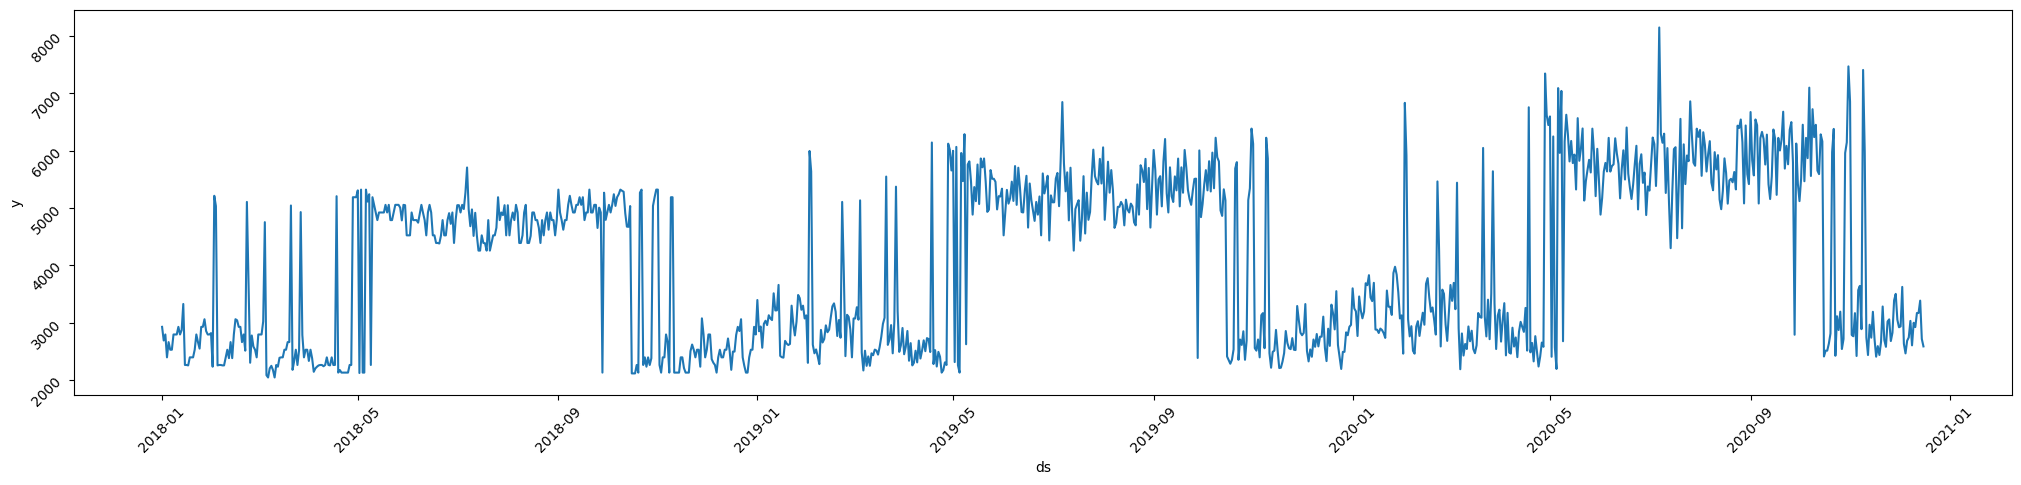

In [120]:
fig, ax = plt.subplots(1,1, figsize=(25,5))
sns.lineplot(data=df_new, x='ds', y='y', ax=ax)
ax.tick_params(rotation=45)
plt.show()


- Evident seasonal period from May to October each year
- Gradual increase in summer sales year on year


## Split the data and fit a model

In [104]:
# Instantiate the Prophet class and then fit the model to the data
m = Prophet()
m.fit(df_new)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2poc9k1/0ie2n3rn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2poc9k1/qgj_7fi8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21948', 'data', 'file=/tmp/tmpd2poc9k1/0ie2n3rn.json', 'init=/tmp/tmpd2poc9k1/qgj_7fi8.json', 'output', 'file=/tmp/tmpd2poc9k1/prophet_modela_2k1y33/prophet_model-20230522100956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [109]:
# Forecast sales for the next year
future = m.make_future_dataframe(periods=365, freq='D')
future

,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
1440,2021-12-12
1441,2021-12-13
1442,2021-12-14
1443,2021-12-15


In [110]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1440,2021-12-12,3573.132390,2581.231714,4600.977432
1441,2021-12-13,3589.166898,2567.100113,4707.031941
1442,2021-12-14,3585.091485,2541.125302,4610.181888
1443,2021-12-15,3614.754353,2537.626112,4715.937983
1444,2021-12-16,3663.179782,2652.484315,4721.197983


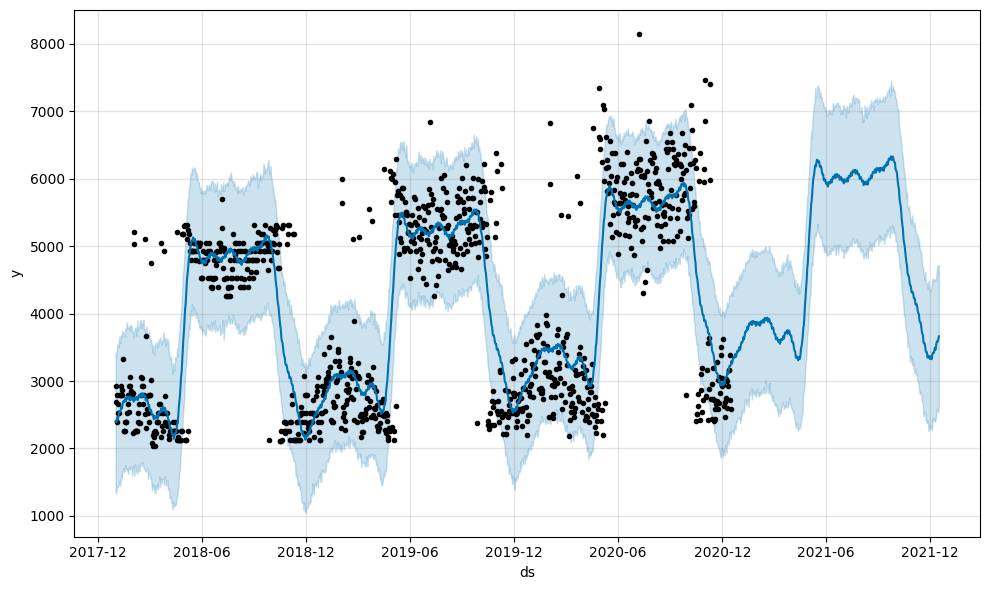

In [112]:
fig1 = m.plot(forecast)

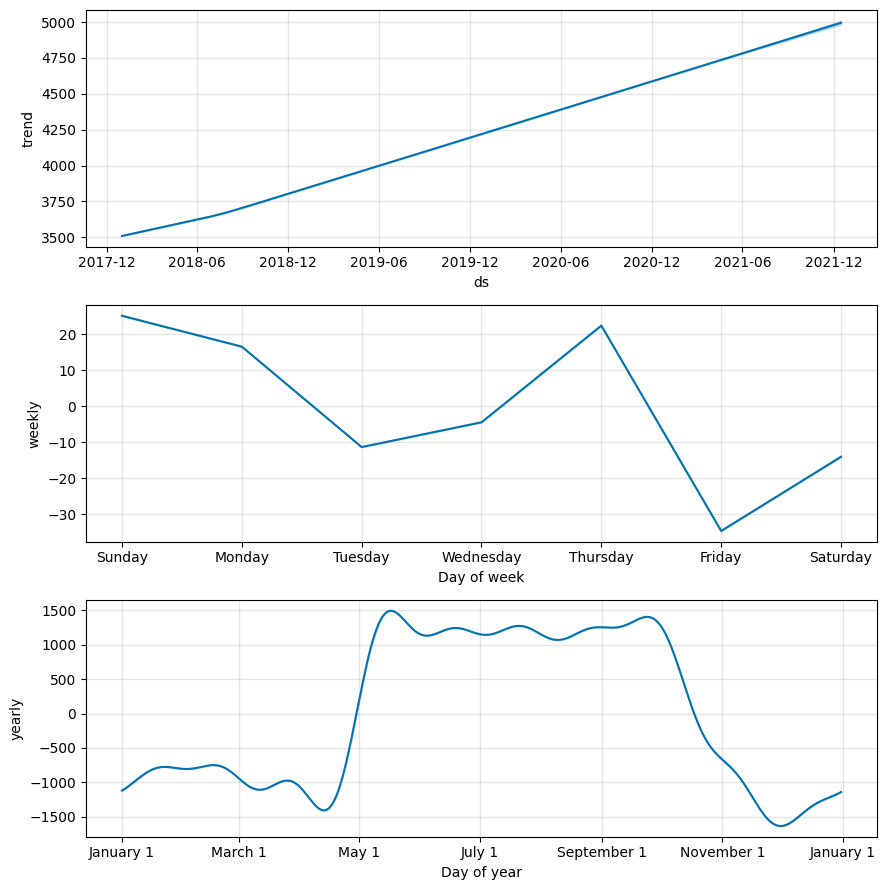

In [118]:
fig2 = m.plot_components(forecast)
